In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Generator, Union
from tensorflow import Tensor, GradientTape, function, concat, ones, zeros, random, cast, constant
from tensorflow.keras.layers import Conv2D, BatchNormalization, add, Input, UpSampling2D, LeakyReLU, Dense, PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam

In [11]:
def generator_net(input_shape: tuple, res_num: int = 1) -> Model:
    """
    Srgan生成器网络

    :param input_shape: 输入图像形状
    :param res_num: 残差块个数
    :return: 生成器网络
    """

    def res_block(y_) -> Tensor:
        """
        残差网络块

        :param y_: 输入
        :return:
        """
        for i in range(res_num):
            _y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(y_)
            _y = BatchNormalization()(_y)
            _y = PReLU()(_y)
            _y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(_y)
            _y = BatchNormalization()(_y)
            y_ = add([_y, y_])
        return y_

    x = Input(shape=input_shape)

    # head
    y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    y = PReLU()(y)

    # body
    y_ = res_block(y)

    y_ = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(y_)
    y_ = BatchNormalization()(y_)
    y = add([y_, y])

    # leg
    y = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(y)
    y = UpSampling2D(size=2)(y)
    y = PReLU()(y)

    y = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(y)
    y = UpSampling2D(size=2)(y)
    y = PReLU()(y)

    y = Conv2D(filters=input_shape[-1], kernel_size=(3, 3), padding="same")(y)
    return Model(inputs=x, outputs=y)

In [12]:
def discriminator_net(input_shape: tuple) -> Model:
    """
    判决器网络

    :param input_shape: 图片输入形状
    :return: 判决器网络
    """
    x = Input(shape=input_shape)

    y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    y = LeakyReLU()(y)

    y = Conv2D(filters=64, kernel_size=(3, 3), padding="same", strides=2)(y)
    y = LeakyReLU()(y)
    y = BatchNormalization()(y)

    y = Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=2)(y)
    y = LeakyReLU()(y)
    y = BatchNormalization()(y)
    y = Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2)(y)
    y = LeakyReLU()(y)
    y = BatchNormalization()(y)

    y = Dense(512)(y)
    y = LeakyReLU()(y)
    y = Dense(1)(y)
    y = sigmoid(y)
    return Model(inputs=x, outputs=y)

In [13]:
gen = generator_net((32, 32, 3))
gen_opt = Adam(learning_rate=0.0004)
gen.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_4 (PReLU)               (None, 32, 32, 64)   65536       conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 64)   36928       p_re_lu_4[0][0]                  
____________________________________________________________________________________________

In [14]:
dis = discriminator_net((128, 128, 3))
dis_opt = Adam(learning_rate=0.0003)
dis.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       7385

In [15]:
def img_to_one(img: Union[Tensor, np.ndarray]):
    """
    归一化

    :param img:
    :return:
    """
    return (img / 255. - 0.5) * 2.

def reverse_img(img: Tensor):
    """
    图片还原

    :param img:
    :return:
    """
    return cast((img + constant(1, dtype="float32")) * 255 / 2, dtype="int32")

def data_loader(img_path: str, batch_size: int) -> Generator:
    img_list = list(Path(img_path).iterdir())
    batch_num = len(img_list) // batch_size
    np.random.shuffle(img_list)
    batch_hr_img_data = []
    batch_lr_img_data = []
    for num in range(0, batch_size * batch_num):
        _img = cv2.cvtColor(cv2.resize(cv2.imread(str(img_list[num]), cv2.IMREAD_COLOR),
                                       (128, 128)), cv2.COLOR_BGR2RGB)
        batch_hr_img_data.append(_img)
        batch_lr_img_data.append(cv2.resize(_img, (32, 32), cv2.INTER_LINEAR))
        if (num + 1) % batch_size == 0:
            hr_data = img_to_one(np.array(batch_hr_img_data, dtype="float32"))
            lr_data = img_to_one(np.array(batch_lr_img_data, dtype="float32"))
            batch_hr_img_data.clear()
            batch_lr_img_data.clear()
            yield hr_data, lr_data, f'{num} / {batch_size * batch_num + 1}'
    batch_hr_img_data.clear()
    batch_lr_img_data.clear()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


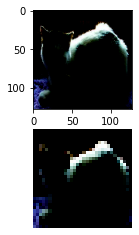

In [16]:
a, b, _ = next(data_loader('../data/training_set/cats', 1))
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(a[0])
plt.subplot(2, 1, 2)
plt.imshow(b[0])
plt.axis("off")
plt.show()

def show_pic(real_img, fake_img):
    plt.figure()
    plt.axis("off")
    plt.subplot(2, 1, 1)
    plt.imshow(real_img[0])
    plt.subplot(2, 1, 2)
    plt.imshow(fake_img[0])
    plt.show()

In [17]:
bc = BinaryCrossentropy(from_logits=False)
vgg19 = VGG19(include_top=False)
vgg19.trainable = False
dis_output_shape = (16, 16, 1)

def content_loss(hr_img: Tensor, fake_hr_img: Tensor, d_preds: Tensor, batch_size: int):
    hr_img = reverse_img(hr_img)
    fake_hr_img = reverse_img(fake_hr_img)
    hr_img = preprocess_input(hr_img)
    fake_hr_img = preprocess_input(fake_hr_img)
    hr_img_f = vgg19(hr_img)
    fake_hr_img_f = vgg19(fake_hr_img)
    return mean_squared_error(hr_img_f, fake_hr_img_f) + bc(ones(shape=(batch_size, *dis_output_shape)), d_preds)


@function
def train_step(hr_img: Tensor, lr_img: Tensor):
    batch_size = hr_img.shape[0]
    fake_hr_img = gen(lr_img)
    img_set = concat([hr_img, fake_hr_img], axis=0)
    img_label = concat([ones(shape=(batch_size, *dis_output_shape)), zeros(shape=(batch_size, *dis_output_shape))], axis=0)
    img_label += 0.05 * random.uniform(img_label.shape)

    with GradientTape() as dis_G:
        d_preds = dis(img_set)
        d_loss = bc(img_label, d_preds)
    d_gradiant = dis_G.gradient(d_loss, dis.trainable_weights)
    dis_opt.apply_gradients(zip(d_gradiant, dis.trainable_weights))

    with GradientTape() as gen_G:
        g_preds = gen(lr_img)
        d_preds = dis(g_preds)
        g_loss = content_loss(hr_img, g_preds, d_preds, batch_size)
    g_gradiant = gen_G.gradient(g_loss, gen.trainable_weights)
    gen_opt.apply_gradients(zip(g_gradiant, gen.trainable_weights))

    return d_loss, g_loss

In [18]:
def train():
    epochs = 2000
    batch_size = 32
    test_img = cv2.cvtColor(cv2.resize(cv2.imread('../data/training_set/dogs/dog.1.jpg', cv2.IMREAD_COLOR), (32, 32), cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB)
    test_img = img_to_one(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    for epoch in range(1, epochs + 1):
        for hr_data, lr_data, info in data_loader('../data/training_set/cats', batch_size):
            d_loss, g_loss = train_step(hr_data, lr_data)
            print(f'\r{epoch=}--{info}--d_loss={d_loss.numpy()}',
                  end='', flush=True)
        print()

        gen_pic = gen(test_img)
        show_pic(test_img, gen_pic)

train()

KeyboardInterrupt: 